<a href="https://colab.research.google.com/github/ShahedNaji/IntroPythonForDS/blob/master/Pictures_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import os
from pathlib import Path
path = Path('/gdrive/MyDrive/downloaded_images')

In [3]:

with open(path/'urls.txt') as f:
  image_urls = f.read().splitlines()

In [4]:
image_urls

['https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/NGC_4414_%28NASA-med%29.jpg/1200px-NGC_4414_%28NASA-med%29.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/8/8c/Andromeda_Galaxy_560mm_FL.jpg',
 'https://cdn.eso.org/images/screen/eso2110b.jpg',
 'http://cdn.spacetelescope.org/archives/images/screen/potw2120a.jpg',
 'http://cdn.eso.org/images/screen/eso2110a.jpg',
 'https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41550-021-01563-1/MediaObjects/41550_2021_1563_Fig1_HTML.png',
 'https://i.natgeofe.com/n/e484088d-3334-4ab6-9b75-623f7b8505c9/1086_16x9.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Antennae_galaxies_xl.jpg/2064px-Antennae_galaxies_xl.jpg',
 'https://www.researchgate.net/profile/Sara-Petty/publication/232244453/figure/fig1/AS:300593747906560@1448678542302/WISE-montage-of-nearby-galaxies-showing-resolution-enhanced-images-of-the-sample_Q640.jpg',
 'https://images.theconversation.com/files/433499/original/file-202

In [6]:
# os.mkdir(path / 'galaxy_images')

In [7]:
import skimage.io as io
from PIL import Image

for index, image_url in enumerate(image_urls):
  # comment out the break to make the loop run and download to drive
  break # <-- THIS
  try:
      downloaded_image = Image.fromarray(io.imread(image_url)[:,:,:3])
      downloaded_image.save(path / 'galaxy_images' / f'image_{index}.jpg')
  except:
    continue
  

In [8]:
# https://github.com/christiansafka/img2vec
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048,
    }

    def __init__(self, cuda=False, model='resnet-34', layer='default',
                 layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[:, :]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(1, self.layer_output_size)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[0, :]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [9]:
# Initialize Img2Vec without GPU
img2vec = Img2Vec(cuda=False)

In [31]:
embeddings_dictionary ={}
imag_names = []
for index, imag in enumerate(os.listdir(path / 'galaxy_images')):
  #import pdb; pdb.set_trace()
  try:
    embeddings_dictionary[imag] = img2vec.get_vec(Image.open(path / 'galaxy_images' / imag))
    #import pdb; pdb.set_trace()
    imag_names.append(imag)
  except:
    continue
  if index > 20: # comment this if statement to compute all embeddings for the folder
    break

In [32]:
embeddings_dictionary.keys()

dict_keys(['image_0.jpg', 'image_1.jpg', 'image_2.jpg', 'image_3.jpg', 'image_4.jpg', 'image_5.jpg', 'image_6.jpg', 'image_7.jpg', 'image_9.jpg', 'image_10.jpg', 'image_12.jpg', 'image_13.jpg', 'image_14.jpg', 'image_16.jpg', 'image_17.jpg', 'image_18.jpg', 'image_19.jpg', 'image_20.jpg', 'image_21.jpg', 'image_22.jpg', 'image_23.jpg', 'image_24.jpg'])

In [33]:
embeddings_dictionary.values()

dict_values([array([5.97270764e-02, 6.90752923e-01, 1.80219531e+00, 1.93046033e-02,
       3.51446904e-02, 1.43374085e+00, 3.70931238e-01, 4.08891726e+00,
       3.11894953e-01, 1.79498628e-01, 4.16235983e-01, 1.47031856e+00,
       3.41618173e-02, 9.55361947e-02, 1.93192422e-01, 0.00000000e+00,
       9.69734907e-01, 3.54764285e-03, 3.46559525e+00, 1.80222213e+00,
       3.50646353e+00, 2.87184298e-01, 7.90893510e-02, 8.32916975e-01,
       5.40347755e-01, 8.59114766e-01, 4.04144414e-02, 6.22757387e+00,
       2.33730412e+00, 1.02466986e-01, 2.29637265e+00, 3.91516238e-01,
       4.02405532e-03, 8.28235388e-01, 1.77567288e-01, 1.26103914e+00,
       4.89885378e+00, 1.66793063e-01, 1.39219975e+00, 2.74493605e-01,
       3.60038489e-01, 2.33193804e-02, 3.14020634e-01, 2.77834713e-01,
       1.88323796e-01, 5.28793156e-01, 2.08580390e-01, 7.58529234e+00,
       1.58839762e+00, 1.31750023e+00, 7.42317885e-02, 4.12430614e-01,
       1.24765418e-01, 0.00000000e+00, 3.41230130e+00, 1.6198146

In [34]:
from numpy import dot
from numpy.linalg import norm

#https://stackoverflow.com/a/43043160/45963
def cosine_similarity(a, b):
  return dot(a, b)/(norm(a)*norm(b))

In [35]:
from collections import defaultdict
# compute all pairwise similarites 
pairwise_similarities = defaultdict(dict)

for image_name, vector in embeddings_dictionary.items():
  for image_name_2, vector_2 in embeddings_dictionary.items():
    pairwise_similarities[image_name][image_name_2] = cosine_similarity(vector, vector_2)


In [36]:
pairwise_similarities['image_0.jpg']

{'image_0.jpg': 1.0000001,
 'image_1.jpg': 0.7767035,
 'image_10.jpg': 0.6890932,
 'image_12.jpg': 0.7068878,
 'image_13.jpg': 0.79902226,
 'image_14.jpg': 0.7484642,
 'image_16.jpg': 0.68425345,
 'image_17.jpg': 0.8032694,
 'image_18.jpg': 0.6428263,
 'image_19.jpg': 0.8071103,
 'image_2.jpg': 0.6936007,
 'image_20.jpg': 0.6237502,
 'image_21.jpg': 0.79139584,
 'image_22.jpg': 0.6739408,
 'image_23.jpg': 0.44034842,
 'image_24.jpg': 0.6573649,
 'image_3.jpg': 0.5321371,
 'image_4.jpg': 0.56148124,
 'image_5.jpg': 0.5459671,
 'image_6.jpg': 0.6901994,
 'image_7.jpg': 0.76772195,
 'image_9.jpg': 0.66702694}

In [37]:
import matplotlib.pyplot as plt
# utility function to show images side to side
def show_pair(imag_a, imag_b): 
  plt.subplot(121)
  plt.imshow(np.array(imag_a))
  plt.axis("off")
  
  plt.subplot(122)
  plt.imshow(np.array(imag_b))
  plt.axis("off")

In [38]:
len(imag_names)

22

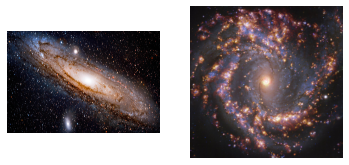

In [40]:
show_pair(Image.open(path / 'galaxy_images/image_1.jpg'), Image.open(path / 'galaxy_images/image_2.jpg'))

In [41]:
len(pairwise_similarities)

22

Cosine similarity = 0.7656


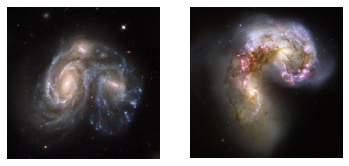

In [52]:
#@title Visualize pairs {run:'auto'}
index = 18  #@param {type: "slider", min: 0, max: 22}
index_2 = 7  #@param {type: "slider", min: 0, max: 22}

cos_sim_value = pairwise_similarities[imag_names[index]][imag_names[index_2]]
print(f'Cosine similarity = {cos_sim_value:.4f}')
show_pair(Image.open(path / 'galaxy_images'/imag_names[index]),
          Image.open(path / 'galaxy_images' /imag_names[index_2]))